In [1]:
import argparse
import glob
import random
import collections
import os
import numpy as np
import scipy.stats

SNPINFO_FIELDS = ['rsid', 'bp_location', 'alt_allele', 'ref_allele', 'studies']
class SnpInfo(collections.namedtuple('_SnpInfo', SNPINFO_FIELDS)):
    __slots__ = ()

In [2]:
locidir = '/scratch/sbanerj/quasi_laplace_gwas/loci_dosages'
simdir = '/scratch/sbanerj/quasi_laplace_gwas/simulations/sim001'
locusnames = '/scratch/sbanerj/quasi_laplace_gwas/LOCUSNAMES.MAXSNPS'
studies = ['G1', 'G2', 'G3', 'G4', 'G5']
sample = [2139, 2420, 2472, 2084, 3967]
cprob = 0.005
sigma_herited_sq = 0.4
sampleprefix = '_QC_age'

In [3]:
def read_locus_prefixes(filename):
    locusprefixes = list()
    with open(filename, 'r') as mfile:
        for line in mfile:
            mline = line.split()
            locusprefixes.append(mline[0].strip())
    return locusprefixes

def read_snps(locidir, studies, locusprefixes):
    nstudy = len(studies)
    snpinfo = list()
    for study in studies:
        snpstudy = list()
        for locusprefix in locusprefixes:
            mapfile = os.path.join(locidir, study, locusprefix + '.map')
            snplocus = list()
            with open(mapfile, 'r') as mfile:
                for line in mfile:
                    mline = line.split()
                    this_snp = SnpInfo(rsid = mline[1],
                                       bp_location = int(mline[3]),
                                       alt_allele = mline[4],
                                       ref_allele = mline[5],
                                       studies = [])
                    snplocus.append(this_snp)
            snpstudy.append(snplocus)
        snpinfo.append(snpstudy)
    return snpinfo

def get_snppool(snpinfo):
    nstudy = len(snpinfo)
    snppool = list()
    nloci = len(snpinfo[0]) # Assumes same number of loci in each study
    for locus in range(nloci):
        snplocus = list()
        for i in range(nstudy):
            snplocus += [snp for snp in snpinfo[i][locus] if snp not in snplocus]
        snppool.append(snplocus)
    return snppool

def select_causal_snps(studies, snpinfo, snppool, locus, prob):
    select = list()
    none_selected = True
    while none_selected:
        for i, snp in enumerate(snppool):
            mrand = random.uniform(0, 1)
            if prob > mrand:
                select.append(snp)
        if len(select) > 0:
            none_selected = False
        #else:
        #    select = list()
    for snp in select:
        present_in = [study for i, study in enumerate(studies) if snp in snpinfo[i][locus]]
        select[select.index(snp)] = snp._replace(studies = present_in)
    return select

In [4]:
locusprefixes = read_locus_prefixes(locusnames)
snpinfo = read_snps(locidir, studies, locusprefixes)
snppool = get_snppool(snpinfo)

In [5]:
nsim = 100
causal_loci = [[0 for x in locusprefixes] for i in range(nsim)]
ncausal = [0 for i in range(nsim)]

for sim in range(nsim):
    for l, locus in enumerate(locusprefixes):
        snps = select_causal_snps(studies, snpinfo, snppool[l], l, cprob)
        ncausal[sim] += len(snps)
        causal_loci[sim][l] = len(snps)

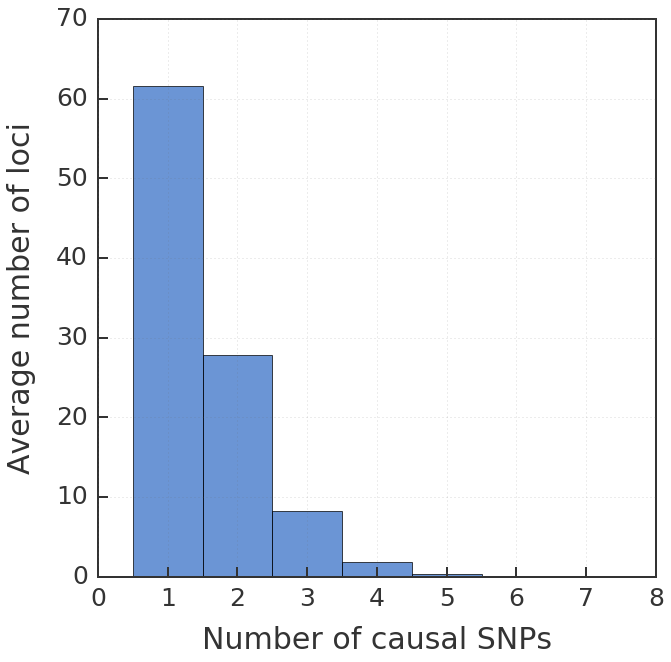

In [6]:
import matplotlib.pyplot as plt

kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray

    # The following don't work well for people with defective color vision
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

banskt_colors_hex = [
    '#2D69C4', # blue 
    '#FFB300', # Vivid Yellow
    '#93AA00', # Vivid Yellowish Green
    '#CC2529', # red
    '#535154', # gray
    '#6B4C9A', # purple
    '#922428', # dark brown
    '#948B3D', # olive
    ]

colors = banskt_colors_hex
marker_list = ['8', '>', 'd', '<', '*', 'p', '^', 's', 'h', 'v', 'D', r'$\clubsuit$']

#bordercolor = '#2B2B2B'
bordercolor = '#333333'
borderwidth = 2
figsize = (12,12)
axis_font_size = 30
label_font_size = 25
legend_font_size = 25

fig = plt.figure(figsize = (10, 10))
ax1 = fig.add_subplot(111)

numcausal = [i for x in causal_loci for i in x]
ax1.hist(numcausal, normed = False, color = colors[0], align='left', bins=[i for i in range(20)], alpha = 0.7)
#ax2.hist(ncausal, normed = True)

mxlabel = 'Number of causal SNPs'
mylabel = 'Average number of loci'

ax1.set_xlabel(mxlabel, {'size': axis_font_size, 'color': bordercolor}, labelpad = 15)
ax1.set_ylabel(mylabel, {'size': axis_font_size, 'color': bordercolor}, labelpad = 20)
ax1.set_ylim(0, 70 * nsim)
ax1.set_xlim(0, 8)
ax1.tick_params(axis='both', which = 'major',
               length = 10, width = borderwidth, pad=10,
               labelsize = label_font_size,
               color = bordercolor,
               labelcolor = bordercolor,
               bottom = True, top = False, left = True, right = False
              )
for side, border in ax1.spines.items():
    border.set_linewidth(borderwidth)
    border.set_color(bordercolor)
ax1.grid(color='dimgray', lw=0.5, alpha=0.5)
yticklabels = ax1.get_yticks().tolist()
ytl = [int(x / nsim) for x in yticklabels]
ax1.set_yticklabels(ytl)
ax1.set_xticks([i for i in range(9)])

plt.savefig('simulation_c_distribution.pdf', bbox_inches='tight')
plt.show()

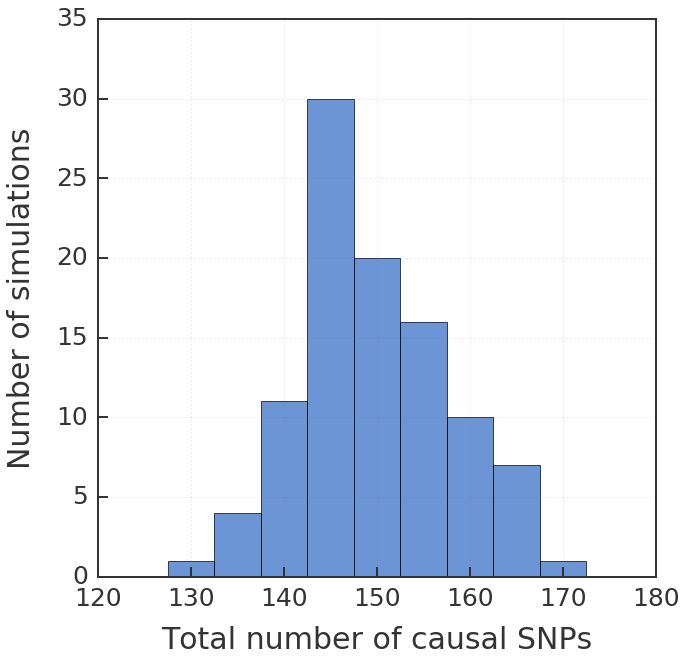

In [12]:
import matplotlib.pyplot as plt

kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray

    # The following don't work well for people with defective color vision
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

banskt_colors_hex = [
    '#2D69C4', # blue 
    '#FFB300', # Vivid Yellow
    '#93AA00', # Vivid Yellowish Green
    '#CC2529', # red
    '#535154', # gray
    '#6B4C9A', # purple
    '#922428', # dark brown
    '#948B3D', # olive
    ]

colors = banskt_colors_hex
marker_list = ['8', '>', 'd', '<', '*', 'p', '^', 's', 'h', 'v', 'D', r'$\clubsuit$']

#bordercolor = '#2B2B2B'
bordercolor = '#333333'
borderwidth = 2
figsize = (12,12)
axis_font_size = 30
label_font_size = 25
legend_font_size = 25

fig = plt.figure(figsize = (10, 10))
ax1 = fig.add_subplot(111)

ax1.hist(ncausal, normed = False, color = colors[0], align='left', alpha = 0.7, bins = np.arange(100, 200, 5))
#ax2.hist(ncausal, normed = True)

mxlabel = 'Total number of causal SNPs'
mylabel = 'Number of simulations'

ax1.set_xlabel(mxlabel, {'size': axis_font_size, 'color': bordercolor}, labelpad = 15)
ax1.set_ylabel(mylabel, {'size': axis_font_size, 'color': bordercolor}, labelpad = 20)
ax1.set_ylim(0, 35)
ax1.set_xlim(120, 180)
ax1.tick_params(axis='both', which = 'major',
               length = 10, width = borderwidth, pad=10,
               labelsize = label_font_size,
               color = bordercolor,
               labelcolor = bordercolor,
               bottom = True, top = False, left = True, right = False
              )
for side, border in ax1.spines.items():
    border.set_linewidth(borderwidth)
    border.set_color(bordercolor)
ax1.grid(color='dimgray', lw=0.5, alpha=0.5)
#yticklabels = ax1.get_yticks().tolist()
#ytl = [int(x / nsim) for x in yticklabels]
#ax1.set_yticklabels(ytl)
#ax1.set_xticks(np.arange(80, 220, 40))
#ax1.set_yticks(np.arange(0,18,4))

plt.savefig('simulation_ctot_distribution.pdf', bbox_inches='tight')
plt.show()